# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (ie 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - 
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [26]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## 1. Data Exploration & Preprocess

In [27]:
print (portfolio.shape, profile.shape,transcript.shape)

(10, 6) (17000, 5) (306534, 4)


In [28]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [4]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [5]:
import time
from datetime import datetime
def transform_time(ts):
    '''transform ts to unixtimestamp, which can be normalized by MinMaxScaler later'''
    return time.mktime(datetime.strptime(str(ts), "%Y%m%d").timetuple())
profile['became_member_on']=profile['became_member_on'].apply(transform_time)
profile.head()

,age,became_member_on,gender,id,income
0,118,1.486858e+09,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,1.500077e+09,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,1.531354e+09,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,1.494288e+09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,1.501805e+09,None,a03223e636434f42ac4c3df47e8bac43,NaN


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f646f898128>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f646f874b00>]], dtype=object)

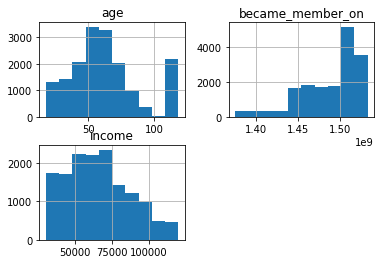

In [6]:
profile.hist()

In [7]:
#remove abnormal records in profile e.g. abnormally large age, records with Null income and gender
valid_profile=profile[(profile['age']<100) & (profile['gender'].notnull()) & (profile['gender'].notnull())].reset_index(drop=True)
valid_profile.head()

,age,became_member_on,gender,id,income
0,55,1.500077e+09,F,0610b486422d4921ae7d2bf64640c50b,112000.0
1,75,1.494288e+09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
2,68,1.524701e+09,M,e2127556f4f64592b11af22de27a7932,70000.0
3,65,1.518134e+09,M,389bc3fa690240e798340f5a15918d5c,53000.0
4,58,1.510358e+09,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


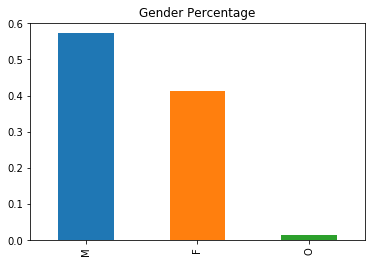

In [8]:
#explore persentage of genders in data set
gender_count=valid_profile['gender'].value_counts()/valid_profile.shape[0]
gender_count.plot(kind='bar', title='Gender Percentage')

In [9]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [10]:
def extract_offer_id(value):
    '''extract offer_id information from value column'''
    key=list(value)[0]
    if 'offer' in key:
        return value[key]
    else:
        return 'Not Applicable'
    
def extract_transaction_amount(value):
    '''extract transaction amount information from value column'''
    try:
        return value['amount']
    except:
        return 0

In [11]:
transcript['offer_id']=transcript['value'].apply(extract_offer_id)
transcript['transaction_amount']=transcript['value'].apply(extract_transaction_amount)
transcript=transcript.drop(['value'],axis=1)
transcript.head()

,event,person,time,offer_id,transaction_amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0


In [12]:
def extract_success_offers(this_group):
    '''input: this_group (grouped dataframe by person and offer_id as key) 
    
       extract successful offers which have the sequence offer received - offer viewed - offer completed.
       if a same type of offer sent to one person multiple times, 
       the last received offer will be extracted if the offer is completed
       
       ouput: output succefully completed offer ids, which are flaged as 1 with asscociated offer information 
       (e.g, offer_received_time, offer_viewed_time and offer_completed_time)
    '''
    this_group=this_group.sort_values('time').reset_index(drop=True)
    event_seq=this_group[this_group['event']!='transaction']['event'].values
    event_seq_index=this_group[this_group['event']!='transaction']['event'].index

    if len(event_seq)>=3:
        seq_comb_list=list(zip(event_seq[0:-2],event_seq[1:-1],event_seq[2:]))
        n=len(seq_comb_list)

        offer_received_time=[]
        offer_viewed_time=[]
        offer_completed_time=[]
        
        for pos in range(n):
            comb=seq_comb_list[pos]
            if (comb[0]=='offer received') & (comb[1]=='offer viewed') & (comb[2]=='offer completed'):
                offer_received_time.append(this_group['time'].iloc[event_seq_index[pos]])
                offer_viewed_time.append(this_group['time'].iloc[event_seq_index[pos+1]])
                offer_completed_time.append(this_group['time'].iloc[event_seq_index[pos+2]])
                
            df=pd.DataFrame({'offer_flag':[1]*len(offer_received_time),'offer_received_time':offer_received_time,'offer_viewed_time':offer_viewed_time,'offer_completed_time':offer_completed_time})
    else:
        df=pd.DataFrame({'offer_flag':[],'offer_received_time':[],'offer_viewed_time':[],'offer_completed_time':[]})
    return df

In [13]:
success_offers=transcript[['event','person','time','offer_id']][transcript['offer_id']!='Not Applicable'].groupby(['person','offer_id']).apply(extract_success_offers).reset_index(level=['person','offer_id']).reset_index(drop=True)
success_offers.head()

,person,offer_id,offer_flag,offer_received_time,offer_viewed_time,offer_completed_time
0,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,408.0,432.0,576.0
1,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1.0,168.0,186.0,252.0
2,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,504.0,516.0,576.0
3,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1.0,408.0,426.0,510.0
4,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,1.0,0.0,12.0,54.0


In [14]:
def extract_fail_offers(this_group):
    '''input: this_group (grouped dataframe by person and offer_id as key) 
    
       extract failed offers which have the sequence offer received - offer viewed - offer not completed.
       if a same type of offer sent to one person multiple times, 
       the last received offer will be extracted 
       
       ouput: output failed to complete offer ids, which are flaged as 0 with asscociated offer information 
       (e.g, offer_received_time, offer_viewed_time and offer_completed_time=None)
    '''
    this_group=this_group.sort_values('time').reset_index(drop=True)
    event_seq=this_group[this_group['event']!='transaction']['event'].values
    event_seq_index=this_group[this_group['event']!='transaction']['event'].index

    if len(event_seq)>=2:
        seq_comb_list=list(zip(event_seq[0:-1],event_seq[1:]))
        n=len(seq_comb_list)

        offer_received_time=[]
        offer_viewed_time=[]

        for pos in range(n):
            comb=seq_comb_list[pos]
            if (comb[0]=='offer received') & (comb[1]=='offer viewed'):
                try:
                    if this_group['event'].iloc[event_seq_index[pos+2]]!='offer completed':  
                        offer_received_time.append(this_group['time'].iloc[event_seq_index[pos]])
                        offer_viewed_time.append(this_group['time'].iloc[event_seq_index[pos+1]])
                except:
                    offer_received_time.append(this_group['time'].iloc[event_seq_index[pos]])
                    offer_viewed_time.append(this_group['time'].iloc[event_seq_index[pos+1]])

        df=pd.DataFrame({'offer_flag':[0]*len(offer_received_time),'offer_received_time':offer_received_time,'offer_viewed_time':offer_viewed_time})
    else:
        df=pd.DataFrame({'offer_flag':[],'offer_received_time':[],'offer_viewed_time':[]})
    
    return df

In [15]:
fail_offers=transcript[['event','person','time','offer_id']][transcript['offer_id']!='Not Applicable'].groupby(['person','offer_id']).apply(extract_fail_offers).reset_index(level=['person','offer_id']).reset_index(drop=True)
fail_offers['offer_completed_time']=None
fail_offers.head()

,person,offer_id,offer_flag,offer_received_time,offer_viewed_time,offer_completed_time
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0,336.0,372.0,None
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0,168.0,192.0,None
2,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,0.0,168.0,216.0,None
3,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,0.0,576.0,630.0,None
4,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,0.0,0.0,6.0,None


In [16]:
##combine all succesful offers and failed offers and calculate offer_completed_duration
all_offers=pd.concat([success_offers,fail_offers],axis=0)
all_offers['offer_completed_duration']=all_offers['offer_completed_time']-all_offers['offer_received_time']
all_offers.head()

,person,offer_id,offer_flag,offer_received_time,offer_viewed_time,offer_completed_time,offer_completed_duration
0,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,408.0,432.0,576,168
1,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1.0,168.0,186.0,252,84
2,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,504.0,516.0,576,72
3,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1.0,408.0,426.0,510,102
4,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,1.0,0.0,12.0,54,54


In [17]:
###merge with protfolio and profile dataframe to add information regarding offer and person
portfolio=portfolio.rename(columns={'id': 'offer_id'})
valid_profile=valid_profile.rename(columns={'id':'person'})
offers_df=all_offers.merge(portfolio[['offer_id','offer_type','duration']],on='offer_id', how='inner').merge(valid_profile,on='person',how='inner')
offers_df.head()

,person,offer_id,offer_flag,offer_received_time,offer_viewed_time,offer_completed_time,offer_completed_duration,offer_type,duration,age,became_member_on,gender,income
0,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,408.0,432.0,576,168,discount,10,40,1.515456e+09,O,57000.0
1,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1.0,168.0,186.0,252,84,discount,7,40,1.515456e+09,O,57000.0
2,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,504.0,516.0,576,72,bogo,7,40,1.515456e+09,O,57000.0
3,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,0.0,0.0,6.0,None,NaN,informational,4,40,1.515456e+09,O,57000.0
4,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,0.0,336.0,354.0,None,NaN,informational,3,40,1.515456e+09,O,57000.0


In [18]:
offers_df.describe()

,offer_flag,offer_received_time,offer_viewed_time,duration,age,became_member_on,income
count,45654.000000,45654.000000,45654.000000,45654.000000,45654.000000,4.565400e+04,45654.000000
mean,0.488457,324.663425,348.932448,6.267425,54.454243,1.487453e+09,65392.649056
std,0.499872,199.650818,199.307209,2.183397,17.100747,3.644386e+07,20993.540542
min,0.000000,0.000000,0.000000,3.000000,18.000000,1.375056e+09,30000.000000
25%,0.000000,168.000000,180.000000,5.000000,43.000000,1.463616e+09,50000.000000
50%,0.000000,336.000000,390.000000,7.000000,55.000000,1.501891e+09,64000.000000
75%,1.000000,504.000000,516.000000,7.000000,66.000000,1.514678e+09,79000.000000
max,1.000000,576.000000,714.000000,10.000000,99.000000,1.532563e+09,120000.000000


In [19]:
bogo_df=offers_df[offers_df['offer_type']=='bogo']
discount_df=offers_df[offers_df['offer_type']=='discount']
info_df=offers_df[offers_df['offer_type']=='informational']
print (bogo_df.shape, discount_df.shape, info_df.shape)

(19741, 13) (16565, 13) (9348, 13)


Class 0 percent:  46.1577427689
Class 1 percent:  53.8422572311


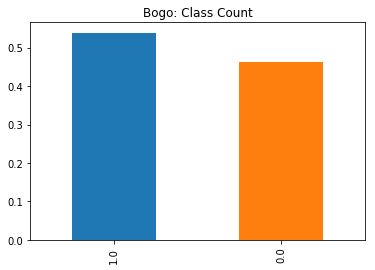

In [20]:
#explore distribution of succesful and failed offers for bogo type offer
bogo_class_count=bogo_df['offer_flag'].value_counts()/bogo_df.shape[0]
print ('Class 0 percent: ', bogo_class_count[0]*100)
print ('Class 1 percent: ', bogo_class_count[1]*100)
bogo_class_count.plot(kind='bar', title='Bogo: Class Count')

Class 0 percent:  29.5442197404
Class 1 percent:  70.4557802596


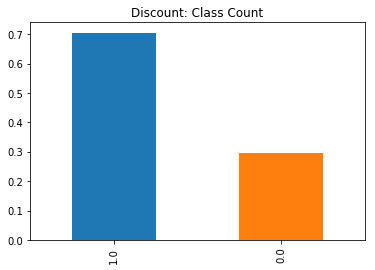

In [21]:
#explore distribution of succesful and failed offers for discount type offer
discount_class_count=discount_df['offer_flag'].value_counts()/discount_df.shape[0]
print ('Class 0 percent: ', discount_class_count[0]*100)
print ('Class 1 percent: ', discount_class_count[1]*100)
discount_class_count.plot(kind='bar', title='Discount: Class Count')

Class 0 percent:  100.0
Class 1 percent:  0.0


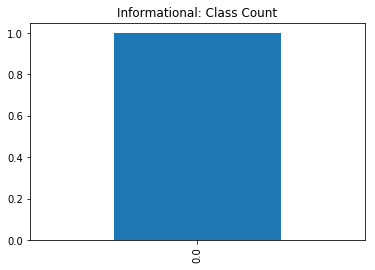

In [22]:
#explore distribution of succesful and failed offers for informational type offer
info_class_count=info_df['offer_flag'].value_counts()/info_df.shape[0]
print ('Class 0 percent: ', info_class_count[0]*100)
print ('Class 1 percent: ', (1-info_class_count[0])*100)
info_class_count.plot(kind='bar', title='Informational: Class Count')

## 2. Algorithm Application

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import fbeta_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

### 2.1 Feature Extraction

In [32]:
#turn gender into dummy variables
offers_data=pd.concat([offers_df,pd.get_dummies(offers_df['gender'])],axis=1).drop(columns=['gender'])
offers_data.head()

,person,offer_id,offer_flag,offer_received_time,offer_viewed_time,offer_completed_time,offer_completed_duration,offer_type,duration,age,became_member_on,income,F,M,O
0,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,408.0,432.0,576,168,discount,10,40,1.515456e+09,57000.0,0,0,1
1,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1.0,168.0,186.0,252,84,discount,7,40,1.515456e+09,57000.0,0,0,1
2,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,504.0,516.0,576,72,bogo,7,40,1.515456e+09,57000.0,0,0,1
3,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,0.0,0.0,6.0,None,NaN,informational,4,40,1.515456e+09,57000.0,0,0,1
4,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,0.0,336.0,354.0,None,NaN,informational,3,40,1.515456e+09,57000.0,0,0,1


In [33]:
## find min max values for all numerical columns and saved in dictionary, which can be used for MinMaxScaler
num_cols=['age','became_member_on','income']
scaler_parameters={}
for col in num_cols:
    min_value=offers_data[col].min()
    max_value=offers_data[col].max()
    scaler_parameters[col]=(min_value,max_value)
scaler_parameters    

{'age': (18, 99),
 'became_member_on': (1375056000.0, 1532563200.0),
 'income': (30000.0, 120000.0)}

In [34]:
## Write a MinMaxScalter function to do normalization for all numerical columns
def MinMaxScaler(value,min_value,max_value):
    '''Normalize the value linearly to adj_value, which is from 0 to 1 '''
    if value <= min_value:
        adj_value=0
    elif value >= max_value:
        adj_value=1
    else:
        adj_value=(value - min_value)/(max_value - min_value)
    return adj_value  

for col in num_cols:
    min_value=scaler_parameters[col][0]
    max_value=scaler_parameters[col][1]
    offers_data[col]=offers_data[col].apply(MinMaxScaler, args=(min_value,max_value))
offers_data.head()

,person,offer_id,offer_flag,offer_received_time,offer_viewed_time,offer_completed_time,offer_completed_duration,offer_type,duration,age,became_member_on,income,F,M,O
0,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,408.0,432.0,576,168,discount,10,0.271605,0.891388,0.3,0,0,1
1,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1.0,168.0,186.0,252,84,discount,7,0.271605,0.891388,0.3,0,0,1
2,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,504.0,516.0,576,72,bogo,7,0.271605,0.891388,0.3,0,0,1
3,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,0.0,0.0,6.0,None,NaN,informational,4,0.271605,0.891388,0.3,0,0,1
4,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,0.0,336.0,354.0,None,NaN,informational,3,0.271605,0.891388,0.3,0,0,1


In [39]:
offers_data[['person','offer_id','offer_flag','age','became_member_on','income','F','M','O']].head()

,person,offer_id,offer_flag,age,became_member_on,income,F,M,O
0,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,0.271605,0.891388,0.3,0,0,1
1,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1.0,0.271605,0.891388,0.3,0,0,1
2,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,0.271605,0.891388,0.3,0,0,1
3,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,0.0,0.271605,0.891388,0.3,0,0,1
4,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,0.0,0.271605,0.891388,0.3,0,0,1


In [35]:
##extract data for each type of offer
bogo_data=offers_data[offers_data['offer_type']=='bogo']
discount_data=offers_data[offers_data['offer_type']=='discount']
info_data=offers_data[offers_data['offer_type']=='informational']

In [36]:
X_bogo=bogo_data[['age','became_member_on','income','F','M','O']]
Y_bogo=bogo_data['offer_flag'].values
X_discount=discount_data[['age','became_member_on','income','F','M','O']]
Y_discount=discount_data['offer_flag'].values

In [37]:
X_bogo_train, X_bogo_test, Y_bogo_train, Y_bogo_test = train_test_split(X_bogo, Y_bogo, test_size=0.3, random_state=42)
X_discount_train, X_discount_test, Y_discount_train, Y_discount_test = train_test_split(X_discount, Y_discount, test_size=0.3, random_state=42)

### 2.2 Model Selection

In [40]:
from time import time
def train_predict(learner, X_train, Y_train, X_test, Y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - Y_train: offer_flag training set
       - X_test: features testing set
       - Y_test: offer_flag testing set
    ouputs:
       dictionary contains performance results
    '''   
    results = {}
    start = time() # Get start time
    learner = learner
    learner.fit(X_train,Y_train)
    end = time() # Get end time
    results['train_time'] = end -start    # Calculate the training time
    
    #  Get the predictions on the test set and train set
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() # Get end time   
    results['pred_time'] = end-start # Calculate the total prediction time
    
    # Compute F-score on the the Y_train
    results['f_train'] = fbeta_score(Y_train,predictions_train,beta=0.5)    
    # Compute F-score on the test set which is Y_test
    results['f_test'] = fbeta_score(Y_test,predictions_test,beta=0.5)
    
    return results

In [41]:
###for results for three candidate models
clf_A = LogisticRegression(random_state=0)
clf_B = svm.SVC(random_state=0)
clf_C = GradientBoostingClassifier(random_state=0)
all_clf=[clf_A,clf_B,clf_C]
bogo_results_dict={}
discount_results_dict={}
for clf in all_clf:
    bogo_results=train_predict(clf, X_bogo_train, Y_bogo_train, X_bogo_test, Y_bogo_test)
    bogo_results_dict[clf.__class__.__name__]=bogo_results
    
    discount_results=train_predict(clf, X_discount_train, Y_discount_train, X_discount_test, Y_discount_test)
    discount_results_dict[clf.__class__.__name__]=discount_results
    

In [42]:
bogo_results_dict

{'LogisticRegression': {'train_time': 0.033255815505981445,
  'pred_time': 0.0010960102081298828,
  'f_train': 0.67931362223535152,
  'f_test': 0.66918886198547212},
 'SVC': {'train_time': 8.565633535385132,
  'pred_time': 7.012171983718872,
  'f_train': 0.69324463375529444,
  'f_test': 0.67853947662715286},
 'GradientBoostingClassifier': {'train_time': 0.6195399761199951,
  'pred_time': 0.033616065979003906,
  'f_train': 0.74288958431415997,
  'f_test': 0.72358247422680411}}

In [43]:
discount_results_dict

{'LogisticRegression': {'train_time': 0.022181034088134766,
  'pred_time': 0.0010499954223632812,
  'f_train': 0.78273742212718722,
  'f_test': 0.7750599520383693},
 'SVC': {'train_time': 5.302253246307373,
  'pred_time': 3.9022133350372314,
  'f_train': 0.75095736299173643,
  'f_test': 0.74376980388798497},
 'GradientBoostingClassifier': {'train_time': 0.5193328857421875,
  'pred_time': 0.027169227600097656,
  'f_train': 0.81412119982872477,
  'f_test': 0.79305453399180414}}

In [92]:
def plot_performance_result(results_dict,offer_type):
    models=['LogisticRegression', 'SVC', 'GradientBoostingClassifier']
    lr_train_time=results_dict['LogisticRegression']['train_time']
    lr_pred_time=results_dict['LogisticRegression']['pred_time']
    lr_f_train=results_dict['LogisticRegression']['f_train']
    lr_f_test=results_dict['LogisticRegression']['f_test']

    svc_train_time=results_dict['SVC']['train_time']
    svc_pred_time=results_dict['SVC']['pred_time']
    svc_f_train=results_dict['SVC']['f_train']
    svc_f_test=results_dict['SVC']['f_test']

    gbc_train_time=results_dict['GradientBoostingClassifier']['train_time']
    gbc_pred_time=results_dict['GradientBoostingClassifier']['pred_time']
    gbc_f_train=results_dict['GradientBoostingClassifier']['f_train']
    gbc_f_test=results_dict['GradientBoostingClassifier']['f_test']



    fig=plt.figure(figsize=(20,6))
    barWidth = 0.5

    plt.subplot(1,4,1)
    plt.bar(0, lr_train_time, color='red', width=barWidth, edgecolor='white', label=models[0])
    plt.bar(1, svc_train_time, color='orange', width=barWidth, edgecolor='white', label=models[1])
    plt.bar(2, gbc_train_time, color='green', width=barWidth, edgecolor='white', label=models[2])
    plt.ylim([0,10])
    plt.title('Model Training Time')
    plt.xticks([0,1,2],models)

    plt.subplot(1,4,2)
    plt.bar(0, lr_pred_time, color='red', width=barWidth, edgecolor='white', label=models[0])
    plt.bar(1, svc_pred_time, color='orange', width=barWidth, edgecolor='white', label=models[1])
    plt.bar(2, gbc_pred_time, color='green', width=barWidth, edgecolor='white', label=models[2])
    plt.ylim([0,10])
    plt.title('Model Predicting Time')
    plt.xticks([0,1,2],models)

    plt.subplot(1,4,3)
    plt.bar(0, lr_f_train, color='red', width=barWidth, edgecolor='white', label=models[0])
    plt.bar(1, svc_f_train, color='orange', width=barWidth, edgecolor='white', label=models[1])
    plt.bar(2, gbc_f_train, color='green', width=barWidth, edgecolor='white', label=models[2])
    plt.ylim([0,1])
    plt.title('F-Score on Training Set')
    plt.xticks([0,1,2],models)

    plt.subplot(1,4,4)
    plt.bar(0, lr_f_test, color='red', width=barWidth, edgecolor='white', label=models[0])
    plt.bar(1, svc_f_test, color='orange', width=barWidth, edgecolor='white', label=models[1])
    plt.bar(2, gbc_f_test, color='green', width=barWidth, edgecolor='white', label=models[2])
    plt.ylim([0,1])
    plt.title('F-Score on Testing Set')
    plt.xticks([0,1,2],models)
    fig.suptitle('Performance Results for Candidate Models for Offer Type: '+offer_type,fontsize=20)


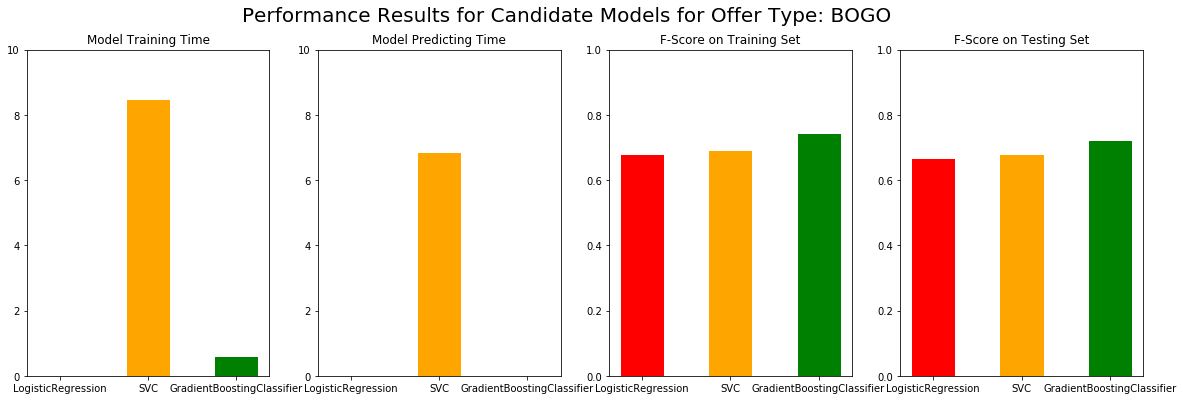

In [93]:
plot_performance_result(bogo_results_dict,'BOGO')

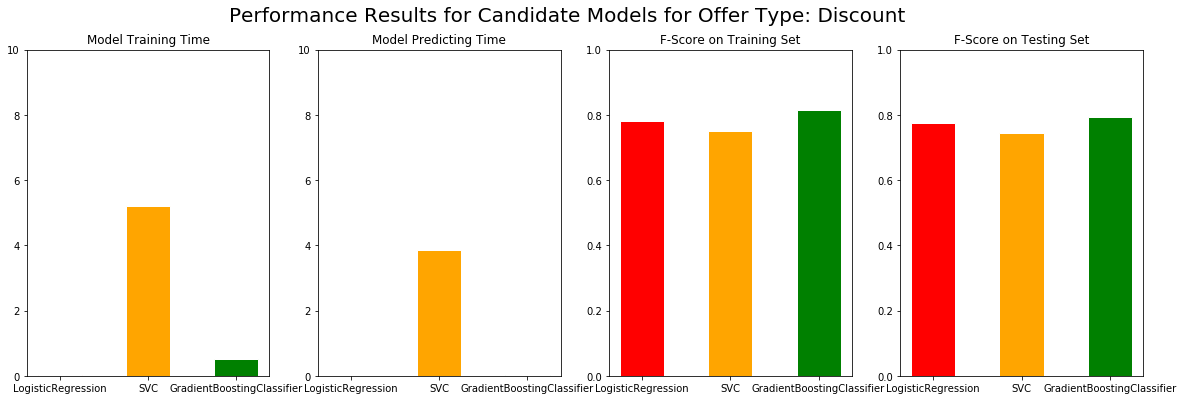

In [94]:
plot_performance_result(discount_results_dict,'Discount')

### 2.3 Parameter Tuning 

In [97]:
parameters = {'loss' : ['deviance', 'exponential'],
              'learning_rate':[0.05,0.1,0.15],
              'n_estimators':[100,150],
              'min_samples_split':[2,5,10],
              'max_depth':[3,4,5]}
scorer = make_scorer(fbeta_score,beta=0.5)

In [98]:
default_model=GradientBoostingClassifier(random_state=0)
bogo_clf = GridSearchCV(default_model, parameters, cv=5,scoring=scorer)
bogo_clf.fit(X_bogo, Y_bogo)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'loss': ['deviance', 'exponential'], 'learning_rate': [0.05, 0.1, 0.15], 'n_estimators': [100, 150], 'min_samples_split': [2, 5, 10], 'max_depth': [3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(fbeta_score, beta=0.5), verbose=0)

In [99]:
bogo_best_model=bogo_clf.best_estimator_
bogo_best_params=bogo_clf.best_params_
bogo_best_score=bogo_clf.best_score_
print ('The best parameter for bogo is: ',bogo_best_params)
print ('The best accuracy for bogo is: ',bogo_best_score)

The best parameter for bogo is:  {'learning_rate': 0.05, 'loss': 'exponential', 'max_depth': 4, 'min_samples_split': 5, 'n_estimators': 100}
The best accuracy for bogo is:  0.723828178601


In [100]:
default_model=GradientBoostingClassifier(random_state=0)
discount_clf = GridSearchCV(default_model, parameters, cv=5,scoring=scorer)
discount_clf.fit(X_discount, Y_discount)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'loss': ['deviance', 'exponential'], 'learning_rate': [0.05, 0.1, 0.15], 'n_estimators': [100, 150], 'min_samples_split': [2, 5, 10], 'max_depth': [3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(fbeta_score, beta=0.5), verbose=0)

In [101]:
discount_best_model=discount_clf.best_estimator_
discount_best_params=discount_clf.best_params_
discount_best_score=discount_clf.best_score_
print ('The best parameter for discount is: ',discount_best_params)
print ('The best accuracy for discount is: ',discount_best_score)

The best parameter for discount is:  {'learning_rate': 0.05, 'loss': 'deviance', 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 150}
The best accuracy for discount is:  0.798247674673


### 2.4 Model Saving

In [5]:
from sklearn.externals import joblib
joblib.dump(bogo_best_model, 'bogo_model.pkl') 
joblib.dump(discount_best_model, 'discount_model.pkl') 

## 3. Strategy Design

In [1]:
from sklearn.externals import joblib
bogo_model = joblib.load('bogo_model.pkl')
discount_model = joblib.load('discount_model.pkl')

In [67]:
scaler_parameters={'age': (18, 99),
 'became_member_on': (1375056000.0, 1532563200.0),
 'income': (30000.0, 120000.0)}

In [63]:
def strategy(age,became_member_on,gender,income,scaler_parameters=scaler_parameters,bogo_model=bogo_model,discount_model=discount_model):
    def MinMaxScaler(value,min_value,max_value):   
        if value <= min_value:
            adj_value=0
        elif value >= max_value:
            adj_value=1
        else:
            adj_value=(value - min_value)/(max_value - min_value)
        return adj_value 
    age=MinMaxScaler(age,scaler_parameters['age'][0],scaler_parameters['age'][1])
    became_member_on=transform_time(became_member_on)
    became_member_on=MinMaxScaler(became_member_on,scaler_parameters['became_member_on'][0],scaler_parameters['became_member_on'][1])
    income=MinMaxScaler(income,scaler_parameters['income'][0],scaler_parameters['income'][1])
    profile_record={'age':[age],'became_member_on':[became_member_on],'income':[income],'F':[0],'M':[0],'O':[0]}
    profile_record[gender]=[1]             
    profile_df=pd.DataFrame.from_dict(profile_record)
    bogo_flag=bogo_model.predict(profile_df)[0]
    discount_flag=discount_model.predict(profile_df)[0]
    if bogo_flag ==1 and discount_flag == 1:
        print ('This person can be provided with offer type bogo, discount and informational')
    elif bogo_flag ==1 and discount_flag ==0:
        print ('This person can be provided with offer type bogo and informational')
    elif bogo_flag ==0 and discount_flag ==1:
        print ('This person can be provided with offer type discount and informational')
    else:
        print ('This person can be provided with offer type informational')
    pass
    

In [65]:
age = 50
became_member_on=20170315
gender='M'
income=40000

strategy(age,became_member_on,gender,income)

This person can be provided with offer type discount and informational


In [70]:
age = 35
became_member_on=20160530
gender='F'
income=80000

strategy(age,became_member_on,gender,income)

This person can be provided with offer type bogo, discount and informational
